<a href="https://colab.research.google.com/github/WereszczynskiClasses/Phys240_Solutions/blob/main/Multidimensional_ODEs_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Differential equations with multiple variables

So far we've dealt with ordinary differential equations that have only one variable and can be written in the form:

$\frac{dx}{dt}= f\left(x,t\right)$

However, you may have noticed that we don't live in a one-dimensional world.  For many physics problems we have multiple variables we need to deal with.  Today, we'll look at how to deal with first-order simultaneous differential equations.  This will form the basis for how we deal with higher order differential equations next week.

The general form of a first-order, two-dimensional differential equation looks like this:

$\frac{dx}{dt}= f_x\left(x,y,t\right)$

$\frac{dy}{dt}= f_y\left(x,y,t\right)$

Note that $f_x$ and $f_y$ are functions of $x, y,$ and $t$. Also note that both derivatives are with respect to $t$ only.  If you had terms such as $\frac{\partial x}{\partial y}$ then we'd be dealing with partial differential equations.

Although they can be much harder to solve analytically than single ODEs, the extension from one-dimensional to multi-dimensional ODEs is fairly straightforward numerically.  In fact, there's really nothing new.  We can still use approaches like Euler's method and the Runge-Kutta methods.  There are two main differences to consider:

1.  You need to keep track of multiple sets of coordinates and update them at each timestep.  
2.  You need to have function(s) that return the velocity in each direction.

Let's first look at some code from last class.  This code solves the fourth order Runge-Kutta method:

```
#user defined variables
start =  0.0
end   = 10.0
x_0   =  1.0
t_0   =  0.0
dt    =  0.001

#velocity function
def f(x,t):
  return x*np.sin(t)**2

#setup our calculations
N = int((end-start)/h) +1 #determine how many points I need. I'm adding 1 to make sure I get both the start and end times
xpoints = np.zeros(N) #define an array for my x values.  Initially set everything to 0.
tpoints= np.zeros(N) #define an array for my time values.  Initially set everything to 0.
xpoints[0] = x_0 #set our initial condition 
tpoints[0] = t_0 #set our initial condition 

#loop over each timestep
for n in range(N-1):
    tpoints[n+1] = h * (n+1)
    x = xpoints[n]
    t = tpoints[n]
    k_1 = h*f(x,t)
    k_2 = h*f(x+ 0.5 *k_1,t+0.5*h)
    k_3 = h*f(x+ 0.5 *k_2,t+0.5*h)
    k_4 = h*f(x+ k_3, t+h)
    xpoints[n+1] = x + (k_1+2*k_2+2*k_3+k_4)/6
```

As a reminder, in the fourth order RK method we calculate the intermediate values $k_1$ to $k_4$ and use them to estimate the average velocity over the timestep, which we use for updating the coordinates for the next timestep. If you need to, go back to the last activity to remind yourself how this works.
**Make sure you understand what this code is doing before proceeding!  If you have questions...ask!**

There are a couple of approaches for how to modify this code to solve multidimensional ODEs:

##The explicit/somewhat dirty approach.  

This involves making new variables for each of your dimensions, including:
1. Separate arrays for each dimension's coordinates.  For example, if you have a 2D system you might have arrays names ```xpoints``` and ```ypoints``` that you update in each step.  

2. Separate functions for each dimension's velocity.  For example, if you have a 2D system you might have functions names ```f_x``` and ```f_y```.  Note that both functions will likely need to take in the current $x$, $y$, and $t$ values.

3. Separate temporary values in your timestep.  For example, if you have a 2D system you might need variables like ```k_1x, k_1y, k_2x, k_2y, ...``` etc.  Note that when you calculate the k values for x you need to call the ```f_x``` function and when you calculate the k values for y you need to call the ```f_y``` function.  For example, if we were doing a fourth order RK method in 2D, the code within each timestep's for loop might look something like this:

```
    tpoints[n+1] = h * (n+1)
    x = xpoints[n]
    y = ypoints[n]
    t = tpoints[n]
    
    k_1x = h*f_x(x,y,t)
    k_1y = h*f_y(x,y,t)

    k_2x = h*f_x(x+ 0.5 *k_1x, y+ 0.5 *k_1y, t+0.5*h)
    k_2y = h*f_y(x+ 0.5 *k_1x, y+ 0.5 *k_1y, t+0.5*h)

    k_3x = h*f_x(x+ 0.5 *k_2x, y+ 0.5 *k_2y, t+0.5*h)
    k_3y = h*f_y(x+ 0.5 *k_2x, y+ 0.5 *k_2y, t+0.5*h)

    k_4x = h*f_x(x+ k_3x, y+ k_3y, t+h)
    k_4y = h*f_y(x+ k_3x, y+ k_3y, t+h)

    xpoints[n+1] = x + (k_1x+2*k_2x+2*k_3x+k_4x)/6
    ypoints[n+1] = y + (k_1y+2*k_2y+2*k_3y+k_4y)/6
```
Note in the code above that you have to be careful with each step to make sure you are calculating the correct value from the correct function and that you are passing in the right "k" value to the correct function at each function call. 

## The vector approach

While the above will work, note how complicated it is for even two dimensions.  Imagine if you had ten particles, each of which was moving in three dimensions.  You would have to explicitly code up 30 different coordinates, along with 30 different sets of $k$ values at each step!  Who wants to read and deal with all of that?

The more elegant approach is to use vector routines.  To modify your 1D code above you would do the following:

1.  Replace your 1D ```xpoints``` array with a multi-dimensional array.  The array should have dimension $ M x N$, where $M$ is the number of dimensions of your system, and $N$ is your number of timesteps.  Typically when we are dealing with multidimensional coordinates we'll use the variable $r$ instead of $x$, so a name such as ```rpoints``` may be more appropriate.

2.  Replace your python $f$ function so that it takes as an input an $M$ dimensional array and the time $t$ and returns an $M$ dimensional array of velocities.

3.  Use these vector formulas in your timesteps to update all of the coordinate at once.

To illustrate this, lets say we wanted to 2D ODE:

$\frac{dx}{dt} = x -y $

$\frac{dy}{dt} = y - x \cdot \sin  t $

you can write your velocity function as:

```
def f(r,t):
  x = r[0]
  y = r[1]
  fx = x-y
  fy = y - x * np.sin(t)
  return np.array([fx,fy])
```

your main code would then look something like this:

```
N = int((end-start)/h) +1 #determine how many points I need. 
rpoints = np.zeros((N,2)) #define an array for my r values.  
tpoints = np.zeros(N) #define an array for my time values.  
rpoints[0] = r_0 #set our initial condition 
tpoints[0] = t_0 #set our initial condition 
for n in range(N-1):
  tpoints[n+1] = h * (n+1)
  r = rpoints[n]
  t = tpoints[n]
  k_1 = h*f(r,t)
  k_2 = h*f(r+ 0.5 *k_1,t+0.5*h)
  k_3 = h*f(r+ 0.5 *k_2,t+0.5*h)
  k_4 = h*f(r+ k_3, t+h)
  rpoints[n+1] = r + (k_1+2*k_2+2*k_3+k_4)/6
```

Note how much simpler this looks, and how it is easier to extend to higher dimensions.  Once you have this code, the hardest part is typically rewriting your ```f(r,t)``` function to give the proper multi-dimensional velocity function.

Take a minute to compare these two solutions.  Make sure you understand why they're equivalent.  

##Activity:

Modify either your code or the solutions from last time to solve the simultaneous differential equations:

$\frac{dx}{dt} = x \cdot y -x$

$\frac{dy}{dt} = y - xy + \sin^2\omega t$

from $t = 0$ to $t = 10$ with initial conditions $x=y=1$ at time $t=0$ and $\omega = 1$.  Plot the results of $x$ vs $t$ and $y$ vs $t$.

In [33]:
import numpy as np
import matplotlib.pyplot as plt

Set your user defined variables for the initial conditions as well as the start and end time and the timestep (which I'm going to do in an array here to test all of these values). I'm also adding the exact answer, which will be useful for error calculations later.

In [34]:
start =  0.0
end   = 50.0
r_0   =  np.array([1.0,1.0])
t_0   =  0.0
h     =  0.01

Define our function f(r,t)

In [35]:
def f(r,t):
  x = r[0]
  y = r[1]
  fx = x*y - x
  fy = y - x*y + np.sin(t)**2
  return np.array([fx,fy])

Here I'm going to do this in a loop over the timesteps so that I can compare the results.

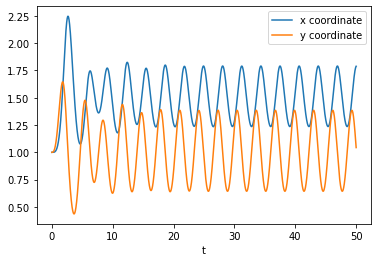

In [36]:
N = int((end-start)/h) +1 #determine how many points I need. I'm adding 1 to make sure I get both the start and end times
rpoints = np.zeros((N,2)) #define an array for my x values.  Initially set everything to 0.
tpoints = np.zeros(N) #define an array for my time values.  Initially set everything to 0.
rpoints[0] = r_0 #set our initial condition 
tpoints[0] = t_0 #set our initial condition 
for n in range(N-1):
  tpoints[n+1] = h * (n+1)
  r = rpoints[n]
  t = tpoints[n]
  k_1 = h*f(r,t)
  k_2 = h*f(r+ 0.5 *k_1,t+0.5*h)
  k_3 = h*f(r+ 0.5 *k_2,t+0.5*h)
  k_4 = h*f(r+ k_3, t+h)
  rpoints[n+1] = r + (k_1+2*k_2+2*k_3+k_4)/6
plt.plot(tpoints,rpoints[:,0],label='x coordinate')
plt.plot(tpoints,rpoints[:,1],label='y coordinate')
plt.xlabel('t')
plt.legend()
plt.show()

# Visualizing your data

When dealing with multidimensional data, it can be hard to make meaningful plots of your data that easily help you understand what is going on with your system.  If your data is in 2D, there are two nice ways to improve the visualization.

The first is to use a scatter plot of the data, and to color your datapoints by your time value.  For example, in this code a spiral is generated in the $x$ and $y$ coordinates as a function of $t$.  The ```scatter``` function in matplotlib is then used to plot the results in the $x/y$ plane.  The ```c=t``` option sets the color of the points to the scale of the values in the array ```t```.  The colorbar command that follows is to turn on the colorbar on the right.

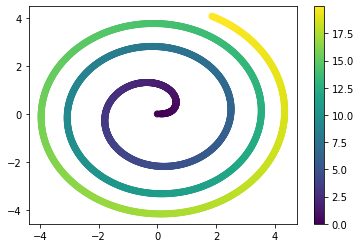

In [37]:
t = np.arange(0,20,.01)
x = np.sqrt(t)*np.cos(t)
y = np.sqrt(t)*np.sin(t)
plt.scatter(x,y,c=t)
plt.colorbar()
plt.show()

**Activity:** Make a scatter plot of your data from above and color the datapoints by their respective times.

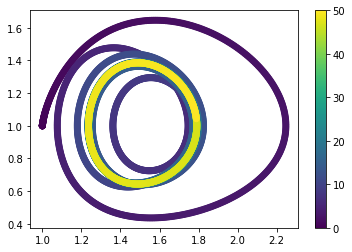

In [38]:
plt.scatter(rpoints[:,0],rpoints[:,1],c=tpoints)
plt.colorbar()
plt.show()

##Animations (optional, if you have time and want to make some fun movies!)

Another good way to visualize data that changes with time is to make an animation.  Animations in python can be a bit tricky, but the general idea is that any animation is simply a series of still frames.  So what we're going to do is make a series of frames of our system at various times and stitch them together.  In python notebooks this is done by making an html5 video file that is embedded in the notebook.  

There are a few ways to do this, but an overall strategy to make an animation is:

1.  Create the background for the animation (including the figure size, axis dimensions, etc.)

2.  Define a function that will draw each frame

3. Create an animation object

4. Render the animation

### Creating the background

For later, we need to setup our figure a bit differently (and more precisely) then we have in the past.  We need to create variables, which we'll call "fig" and "ax1" which point towards the figure we are creating and the axes on the figure.

Text(0, 0.5, 'Y')

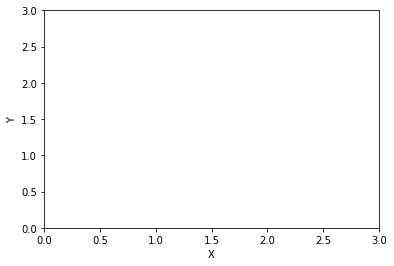

In [39]:
# create a figure and axes
fig = plt.figure()
ax1 = plt.subplot()

# set up the plot as needed
ax1.set_xlim(( 0,3))            
ax1.set_ylim((0,3))
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

We also have to define the things that are going to change between each frame.  Note that they are initially empty with no values, but we're going to change that later.

In [40]:
# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('')
pt1, = ax1.plot([], [], 'g.', ms=20)

## Define a function to draw each frame

This function is the workhorse of the animation routine.   The variable `n` will be the frame number.  The function draws the frame by resetting the data values for the global objects `txt_title` and `pt1`.

In [41]:
# animation function. This is called sequentially
def drawframe(n):
    pt1.set_data(rpoints[n,0],rpoints[n,1])
    txt_title.set_text('Time = {0:4f}'.format(tpoints[n]))
    return()

## Create the Animation Object

The animation class includes a function `FuncAnimation` that incorporations a user-specified function to update the figure for each frame of the animation. The result is an animation object which is subsequently called to actually produce the desired animation.

In [42]:
from matplotlib import animation

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(tpoints), interval=2, blit=True)

## Render the Animation

The final step is to actually render and display the desired animation. This is the compute-intensive step in the procedure. The next cell imports `HTML` which is used to display a HTML elements created in a python script. The animation is rendered to html5 video with the `to_html5_video()` function and then displayed with `HTML()`.

In [43]:
from IPython.display import HTML
HTML(anim.to_html5_video())

As an excercise, see if you can change the above code to animate the results from your ODEs in the first activity. 


For more details and in-depth examples, this is a nice resource:

https://colab.research.google.com/github/jckantor/CBE30338/blob/master/docs/A.03-Animation-in-Jupyter-Notebooks.ipynb